# Live phylogeny project

### Francisco Acosta, 183270

Mi proyecto consistió en una implementación en python del algoritmo de filogenia de vecinos más cercanos con ancestros (LNJ, por su nombre en inglés, live neighbor-joining phylogeny) [desarrollada por Telles y colegas en 2018](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2162-x). Los detalles del algoritmo pueden consultarse en la publicación respectiva, pero de manera general el flujo de trabajo puede resumirse con el siguiente diagrama:

![](https://media.springernature.com/lw785/springer-static/image/art%3A10.1186%2Fs12859-018-2162-x/MediaObjects/12859_2018_2162_Figa_HTML.gif)

Como podemos ver, éste es un proceso iterativo, no paralelizable, donde en cada paso evaluamos la rama o nodo más probable y lo agregamos al árbol. Es particularmente útil para poder generar hipótesis sobre la posible ascendencia evolutiva de los organismos, permitiendo representar organismos como nodos terminales en un árbol que se bifurca (una característica de los árboles tradicionales) o como ancestros de otros (una posibilidad nueva que este método ofrece).

Mi proyecto está diseñado como una librería que te permite importar matrices de distancias, generar árboles de LNJ y graficarlos. Una vez que esté disponible para descargar, el proyecto tendrá sus dependencias declaradas explícitamente, pero por el momento sólo lo importaremos como script, así que tenemos que asegurarnos que están instaladas. Las dependencias son los paquetes `numpy`, `pandas`, `matplotlib`, `Bio` e `io`. (Nota: Benja, si te manda algún error relacionado con `Bio`, escríbeme. Lo instalé en mi linux y no tuvo problema, pero cuando lo instalé en Windows tuvo un error relacionado con el nombre de folder con que se instaló).

Probemos las dependencias.

In [14]:
import numpy as np
import pandas as pd
import os
from math import inf
import matplotlib.pyplot as plt
import re
from Bio import Phylo
import io

Si no tenemos errores, podemos continuar. El primer elemento del paquete es `leer_matriz`, que lee nuestro archivo de distancias como un pandas dataframe y lo prepara para el análisis subsecuente. El único argumento de esta función es el path del archivo. Cargarlo como dataframe en vez de matriz es útil, pues nos permite manipular las columnas y renglones por los nombres de los taxones de forma explícita. Para nuestro primer ejemplo, leeremos un árbol de distancias del virus del Zika, que es uno de los ejemplos del artículo de Telles.

In [15]:
from IPython.display import display
import livephyl as lnj
zika = lnj.leer_matriz('data/matrix-zika')

El archivo se ve de la siguiente forma. Las columnas y renglones son todos los taxones, y los elementos son las distancias entre las secuencias genéticas.

In [16]:
(zika)

0                                       Yap_2007_EU545988  \
0                                                           
Yap_2007_EU545988                                0.000000   
Malaysia_1966_HQ234499                           0.227301   
Nigeria_1968_HQ234500                            0.712323   
Senegal_1984_HQ234501                            0.724454   
Cambodia_2010_JN860885                           0.060416   
Central_African_Republic_1979_KF268948           0.720228   
Central_African_Republic_1980_KF268949           0.719308   
Central_African_Republic_1976_KF268950           0.725876   
Central_African_Republic_1968_KF383115           0.707847   
Senegal_1968_KF383116                            0.715148   
Senegal_1997_KF383117                            0.715732   
Senegal_2001_KF383118                            0.713006   
Senegal_2001_KF383119                            0.692173   
Thailand_2013_KF993678                           0.077745   
French_Polynesia_2013_KJ776791                   0.099526   
Brazil_2015_KU321639                             0.103112   
Puerto_Rico_2015_KU501215                        0.109944   
Guatemala_Nov_2015_KU501216                      0.091803   
Guatemala_Dec_2015_KU501217                      0.091706   
Uganda_1947_LC002520                             0.705109   

0                                       Malaysia_1966_HQ234499  \
0                                                                
Yap_2007_EU545988                                     0.227301   
Malaysia_1966_HQ234499                                0.000000   
Nigeria_1968_HQ234500                                 0.633918   
Senegal_1984_HQ234501                                 0.667446   
Cambodia_2010_JN860885                                0.243938   
Central_African_Republic_1979_KF268948                0.656171   
Central_African_Republic_1980_KF268949                0.650843   
Central_African_Republic_1976_KF268950                0.659817   
Central_African_Republic_1968_KF383115                0.620466   
Senegal_1968_KF383116                                 0.657368   
Senegal_1997_KF383117                                 0.678594   
Senegal_2001_KF383118                                 0.673142   
Senegal_2001_KF383119                                 0.643737   
Thailand_2013_KF993678                                0.255071   
French_Polynesia_2013_KJ776791                        0.266973   
Brazil_2015_KU321639                                  0.280783   
Puerto_Rico_2015_KU501215                             0.274160   
Guatemala_Nov_2015_KU501216                           0.271408   
Guatemala_Dec_2015_KU501217                           0.269656   
Uganda_1947_LC002520                                  0.657335   

0                                       Nigeria_1968_HQ234500  \
0                                                               
Yap_2007_EU545988                                    0.712323   
Malaysia_1966_HQ234499                               0.633918   
Nigeria_1968_HQ234500                                0.000000   
Senegal_1984_HQ234501                                0.141033   
Cambodia_2010_JN860885                               0.704288   
Central_African_Republic_1979_KF268948               0.438662   
Central_African_Republic_1980_KF268949               0.417416   
Central_African_Republic_1976_KF268950               0.443397   
Central_African_Republic_1968_KF383115               0.410028   
Senegal_1968_KF383116                                0.109974   
Senegal_1997_KF383117                                0.223213   
Senegal_2001_KF383118                                0.432442   
Senegal_2001_KF383119                                0.407786   
Thailand_2013_KF993678                               0.721754   
French_Polynesia_2013_KJ776791                       0.710945   
Brazil_2015_KU321639                                 0.719979   
Puerto_Rico_2015_KU501215         

Ya con esto, podemos calcular el árbol LNJ, utilizando la función `crear árbol`. El output de esta función es un string de texto, con el árbol representado en el formato Newick, que es uno de los formatos estándar para árboles. En el futuro pienso incorporar más formatos de representación como opciones adicionales, pero por el momento éste funciona.

In [17]:
zika_tree = lnj.crear_arbol(zika)

Y, finalmente, podemos usar la función `graficar_arbol` para visualizarlo. Esta función parsea la string en formato Newick con `IO` y la grafica con la función `Phylo.draw` del paquete `Bio`. Tiene dos argumentos: el archivo del árbol y el parámetro `tamano`, que es una lista con el alto y el ancho del árbol.

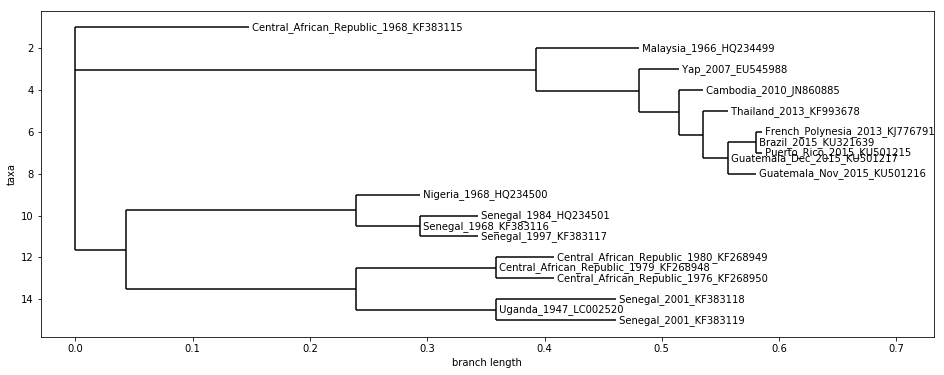

In [22]:
lnj.graficar_arbol(zika_tree)

Como podemos ver, tenemos un árbol con tres ramas principales para el virus del Zika. Podemos ver que algunas variantes sí funcionan como ancestros de otras dos, como es el caso de *Uganda_1947_LC002520* en la rama inferior, *Senegal_1968_KF383116* enmedio o *Brazil_2015_KU321639* en la parte superior.

Hagamos ahora otra prueba, usando otro virus: ébola, un filovirus endémico a África Central y protagonista de varias películas mediamente alarmistas.

![](https://www.thewrap.com/images/2014/10/contagion_poster.jpg)

Sí, solo un poco alarmistas.

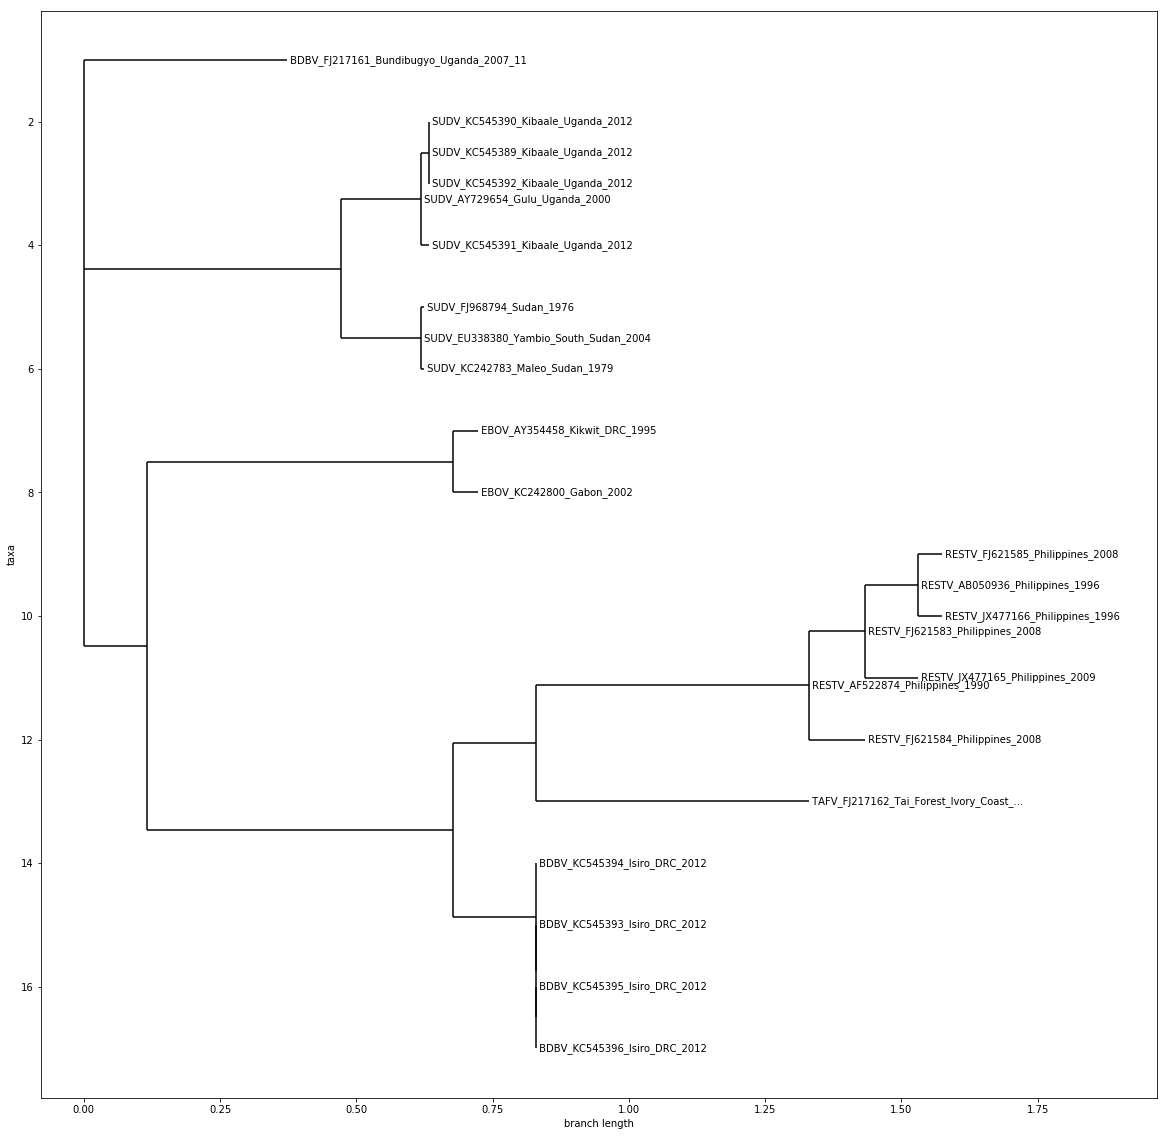

In [23]:
ebola = lnj.leer_matriz('data/matrix-ebola')
ebola_tree = lnj.crear_arbol(ebola)
lnj.graficar_arbol(ebola_tree, tamano = [20,20])

Podemos notar que en algunas ramas las variantes son prácticamente idénticas, resultando en secuencias que parecen salir de una línea recta vertical. Aquí también podemos ver secuencias ancestrales que aparecen en los nodos cercanos a las ramas: en la parte central tenemos *RESTV_AF522874_Philippines_1990*, *RESTV_FJ621583_Philippines_2008* y *AB050936_Philippines_1996*. Curiosamente, en las Filipinas no han habido casos de ébola: esta rama representa a un filovirus llamado Reston, que infecta a cerdos y macacos y que ha aparecido en algunos centros de investigación de primates, incluyendo un centro en Estados Unidos. En la otra rama tenemos otros casos de ancestros, como *SUDV_AY7229654_Gulu_Uganda_2000* y otros.

Un detalle a notar es que en estos árboles los ancestros tienden a aparecer en los nodos más cercanos a las ramas. Esto es de esperarse, ya que es más probable que queden ancestros vivos cuando el tiempo de divergencia es más cercano; esperar que un antepasado remoto de las especies haya sobrevivido sin cambios es poco plausible, a menos que hayamos obtenido las secuencias de fósiles, muestras antiguas conservadas o alguna otra fuente similar.

Ahora, avancemos en la escala evolutiva de nuestras muestras. Podemos aplicar este método a algunas familias de bacterias, organismos más complejos y con secuencias genómicas mucho más grandes.

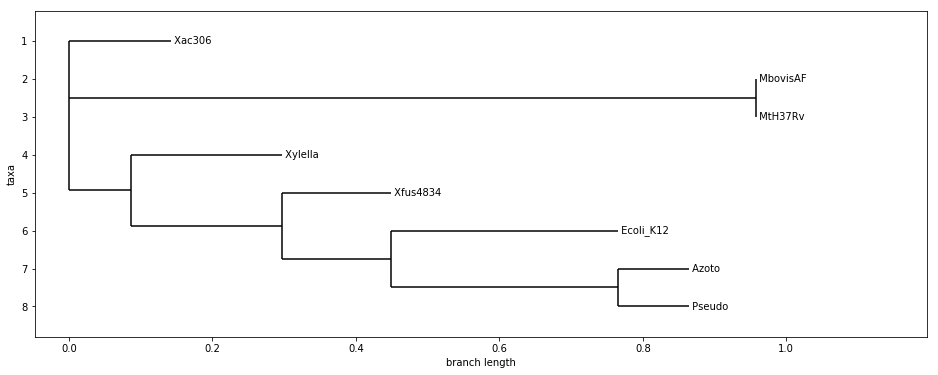

In [24]:
bac = lnj.leer_matriz('data/matrix-bacteria')
bac_tree = lnj.crear_arbol(bac)
lnj.graficar_arbol(bac_tree)

Los resultados son bastante coherentes, aunque en este caso no vemos ningún ancestro común en el árbol. Esto no es particularmente raro, si consideramos las enorme distancias evolutivas entre cada especie y el hecho de que tengamos tan pocas especies en el árbol. Sería interesante aplicar el algoritmo a un grupo de secuencias más relacionada; a todas las variantes y cepas de _Pseudomonas_, por ejemplo.

Finalmente, usaremos un grupo de secuencias de dinosaurios como ejemplo final porque... porque me encantan los dinosaurios. En este caso no usamos secuencias genéticas para calcular las distancias, sino una matriz de caracteres que codifica 204 características de 18 grupos de dinosaurios del clado Tetanurae, que incluye a la mayoría de los terópodos (_Tyrannosaurus_, _Velociraptor_ y similares). La información proviene del artículo _The evolution of dinosaurs_, de Paul Sereno (1999).

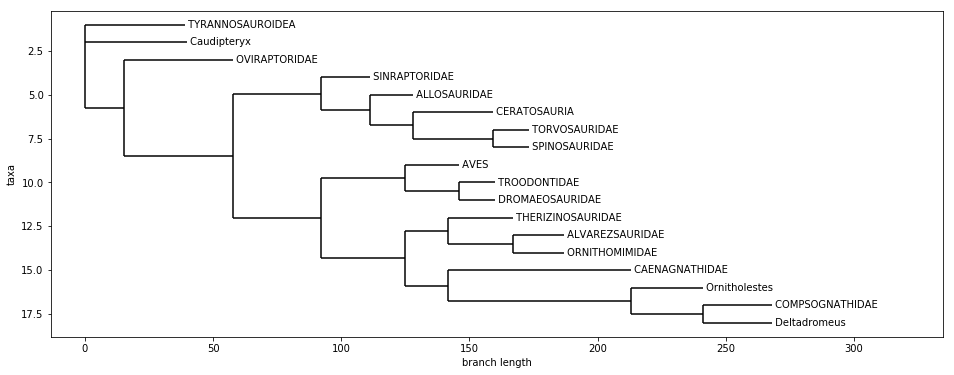

In [25]:
dino = lnj.leer_matriz('data/matrix-dino')
dino_tree = lnj.crear_arbol(dino)
lnj.graficar_arbol(dino_tree)

Nuevamente, tenemos un árbol correcto de acuerdo con estimaciones del artículo, aunque tampoco tenemos antepasados directos. Como se mencionó anteriormente, sería necesario tener árboles con muchas más secuencias más cercanas entre sí para poder comprobar esto; sin embargo, no pude localizar datasets de este tipo ya procesados en la literatura. Por otro lado, igual existe la posibilidad de que este procedimiento no funcione con secuencias de organismos de evolución relativamente lenta (animales, plantas, bacterias) y que su uso esté restringido a virus, que tienen tasas de evolución mucho más rápidas. Sería necesario probarlo con muchos datasets para comprobar esto.

### ¿Qué falta por hacer?

Aunque lo intenté, no pude concluir la implementación que permita calcular árboles finales a partir de subárboles y así poder paralelizar el método. Eso es algo que tendré que ver en el futuro, para la publicación.

Adicionalmente, el código tiene un _bug_ con algunos árboles muy grandes, que por algún motivo se quedan sin columnas al final del proceso. Tengo que hacer un _debugging_ más detallado (revisar los resultados iteración tras iteración) para encontrar la causa.

### Bibliografía

Telles, G. P., Araújo, G. S., Walter, M. E., Brigido, M. M., & Almeida, N. F. (2018). _Live neighbor-joining_. BMC bioinformatics, 19(1), 172.

Sereno, P. C. (1999). _The evolution of dinosaurs_. Science, 284(5423), 2137-2147.